This is how much space the figure will take up on letter paper


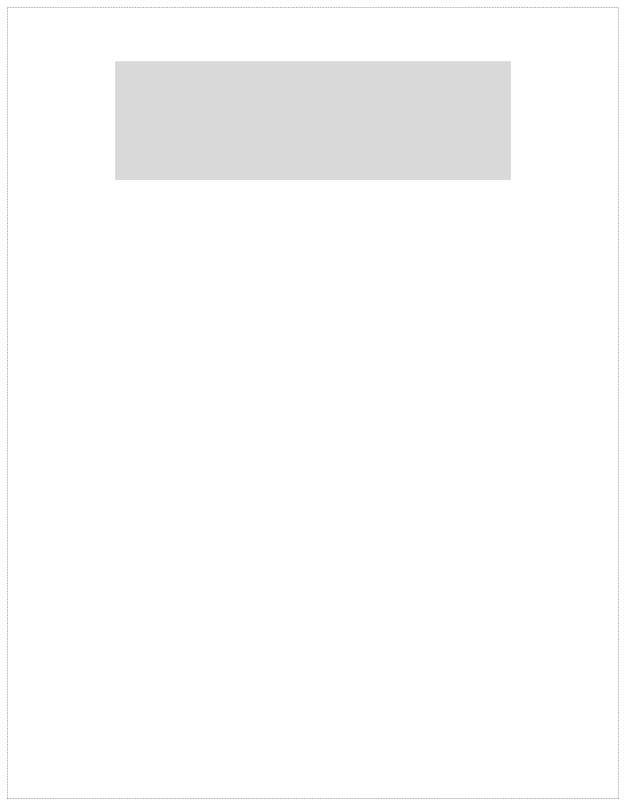

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'motivation'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.65

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim

from symfac.experimental import RBFExpansionV2

/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


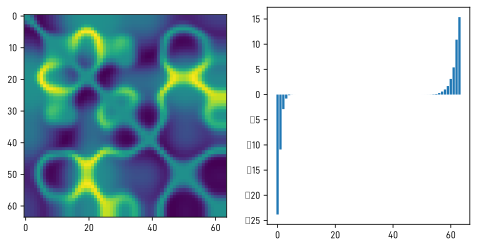

[0.12843, 0.07073, 0.04168, 0.0127, 0.0056, 0.00325, 0.00121, 0.00052, 0.00027]


In [3]:
def rbf(X, Y=None):
    return np.exp(-np.subtract.outer(X, Y if Y is not None else X)**2)

n = 64

np.random.seed(78963)
u = 5 * np.random.randn(n)
v = 4 * np.random.randn(n)
U = gaussian_filter1d(u, 3., order=0)
V = gaussian_filter1d(v, 6., order=0)

K = rbf(U) - rbf(V)
Kt = torch.tensor(K, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(K)
axs[1].bar(np.arange(n), np.linalg.eigvalsh(K))
plt.show()

U, S, V = np.linalg.svd(K)
svd_K = []
for k in range(1, 10):
    truncation = (U[:, :k] * S[None, :k]) @ V[:k, :]
    svd_K.append(round(float(F.mse_loss(torch.tensor(truncation), torch.tensor(K))), 5))
print(svd_K)

In [4]:
fac = RBFExpansionV2(k=1, batch_size=64).fit(K.astype(np.float32))

100%|██████████| 10000/10000 [00:17<00:00, 585.58it/s]


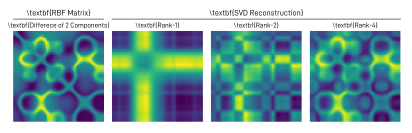

In [79]:
fig = SuperFigure(plt.figure(figsize=(__WIDTH__, __HEIGHT__), dpi=300))
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.01
dx = 0.25
w = 0.23
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        width=w,
        top=0.2,
        width_to_height=1.0,
        style='modern'
    ) for i in range(4)
]

def svd_reconstruction(k):
    U, S, V = np.linalg.svd(K)
    return torch.tensor((U[:, :k] * S[None, :k]) @ V[:k, :])

image_style = dict(
    cmap='viridis'
)
axs[0].imshow(K, **image_style)
axs[1].imshow(svd_reconstruction(1), **image_style)
axs[2].imshow(svd_reconstruction(2), **image_style)
axs[3].imshow(svd_reconstruction(4), **image_style)

title_style = dict(
    fontsize=7,
    y=0.96,
    va='bottom'
)
axs[0].set_title(r'\textbf{Differece of 2 Components}', **title_style)
axs[1].set_title(r'\textbf{Rank-1}', **title_style)
axs[2].set_title(r'\textbf{Rank-2}', **title_style)
axs[3].set_title(r'\textbf{Rank-4}', **title_style)

for ax in axs:
    ax.patch.set_facecolor('w')
    ax.set_xticks([])
    ax.set_yticks([])

ax_group_rbf = fig.make_axes(
    left=axs[0].left, right=axs[0].right, top=0, bottom=1,
    style='blank', zorder=-10
)
ax_group_svd = fig.make_axes(
    left=axs[1].left, right=axs[3].right, top=0, bottom=1,
    style='blank', zorder=-10
)
for ax_group in [ax_group_rbf, ax_group_svd]:
    ax_group.axhline(
        0.9,
        lw=0.5,
        color='k',
    )
group_text_style = dict(
    fontsize=8,
    ha='center',
    va='bottom',
)
ax_group_rbf.text(0.5, 0.92, r'\textbf{RBF Matrix}', **group_text_style)
ax_group_svd.text(0.5, 0.92, r'\textbf{SVD Reconstruction}', **group_text_style)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [80]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1

Successfully created fig-motivation.pdf


# Sandbox below

---